<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/8_Linear_unsupervised_learning/8_5_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Chapter 8: Linear Unsupervised Learning

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

# 8.5  K-Means Clustering

In Sectio 8.3 we saw how Principal Component Analysis can be used as a basis for various normalization schemes, as well as a tool for simplifying a high dimensional dataset by properly reducing its *input* or *feature* dimension.  The subject of this Section is another tool for simplifying data, however here the problem is not (necessarily) that the data lives in high dimension but that there are simply too many data points to process (either by an algorithm or a human interpreter).  The focus of this Section - the *K-means algorithm* - is an elementary example of another set of unsupervised learning methods called *clustering algorithms*.  These algorithms are designed to (properly) reduce the number of points in a dataset, which we refer to as the *data dimension* of a dataset, and in doing so help us understand the structure of our data.

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone datasets
if not Path('chapter_8_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_datasets
else:
    print('chapter_8_datasets already cloned!')

# clone library subdirectory
if not Path('chapter_8_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_library
else:
    print('chapter_8_library already cloned!')

# clone images
if not Path('chapter_8_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_images
else:
    print('chapter_8_images already cloned!')

# clone videos
if not Path('chapter_8_videos').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_videos
else:
    print('chapter_8_videos already cloned!')


# append path for local library, data, and image import
import sys
sys.path.append('./chapter_8_library') 
sys.path.append('./chapter_8_images') 
sys.path.append('./chapter_8_datasets') 

# import section helper
import section_8_5_helpers

# image paths
image_path_1 = "chapter_8_images/Kmeans_1.png"
image_path_2 = "chapter_8_images/Kmeans_2.png"
image_path_3 = "chapter_8_images/Kmeans_3.png"

# video paths
video_path_1 = 'chapter_8_videos/animation_3.mp4'
video_path_2 = 'chapter_8_videos/animation_4.mp4'
video_path_3 = 'chapter_8_videos/animation_5.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import autograd.numpy as np
from matplotlib import gridspec
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_8_datasets already cloned!
chapter_8_library already cloned!
chapter_8_images already cloned!
chapter_8_videos already cloned!


##  Representing a dataset via clusters

One very simple way to simplify a dataset is by grouping together nearby points into *clusters*.  Take the following set of two-dimensional data points, shown in the left panel below.  When you look at the image of this data you can see that it naturally falls into three groups or *clusters*, because you have something along the lines of a clustering algorithms 'built in' to your mental software (along with many other pattern recognition abilities).  

In the right panel we project a visual representation of each cluster onto the data, including each cluster's boundary drawn as a uniquely colored solid curve. We also draw the center of each cluster using a star symbol that matches the unique boundary color of each cluster. These cluster centers are often referred to in the jargon of machine learning as cluster *centroids*. The centroids here allow us to think about the dataset in the big picture sense - instead of $P = 10$ points we can think of our dataset grossly in terms of these $K=3$ cluster centroids, as each represents a chunk of the data.  

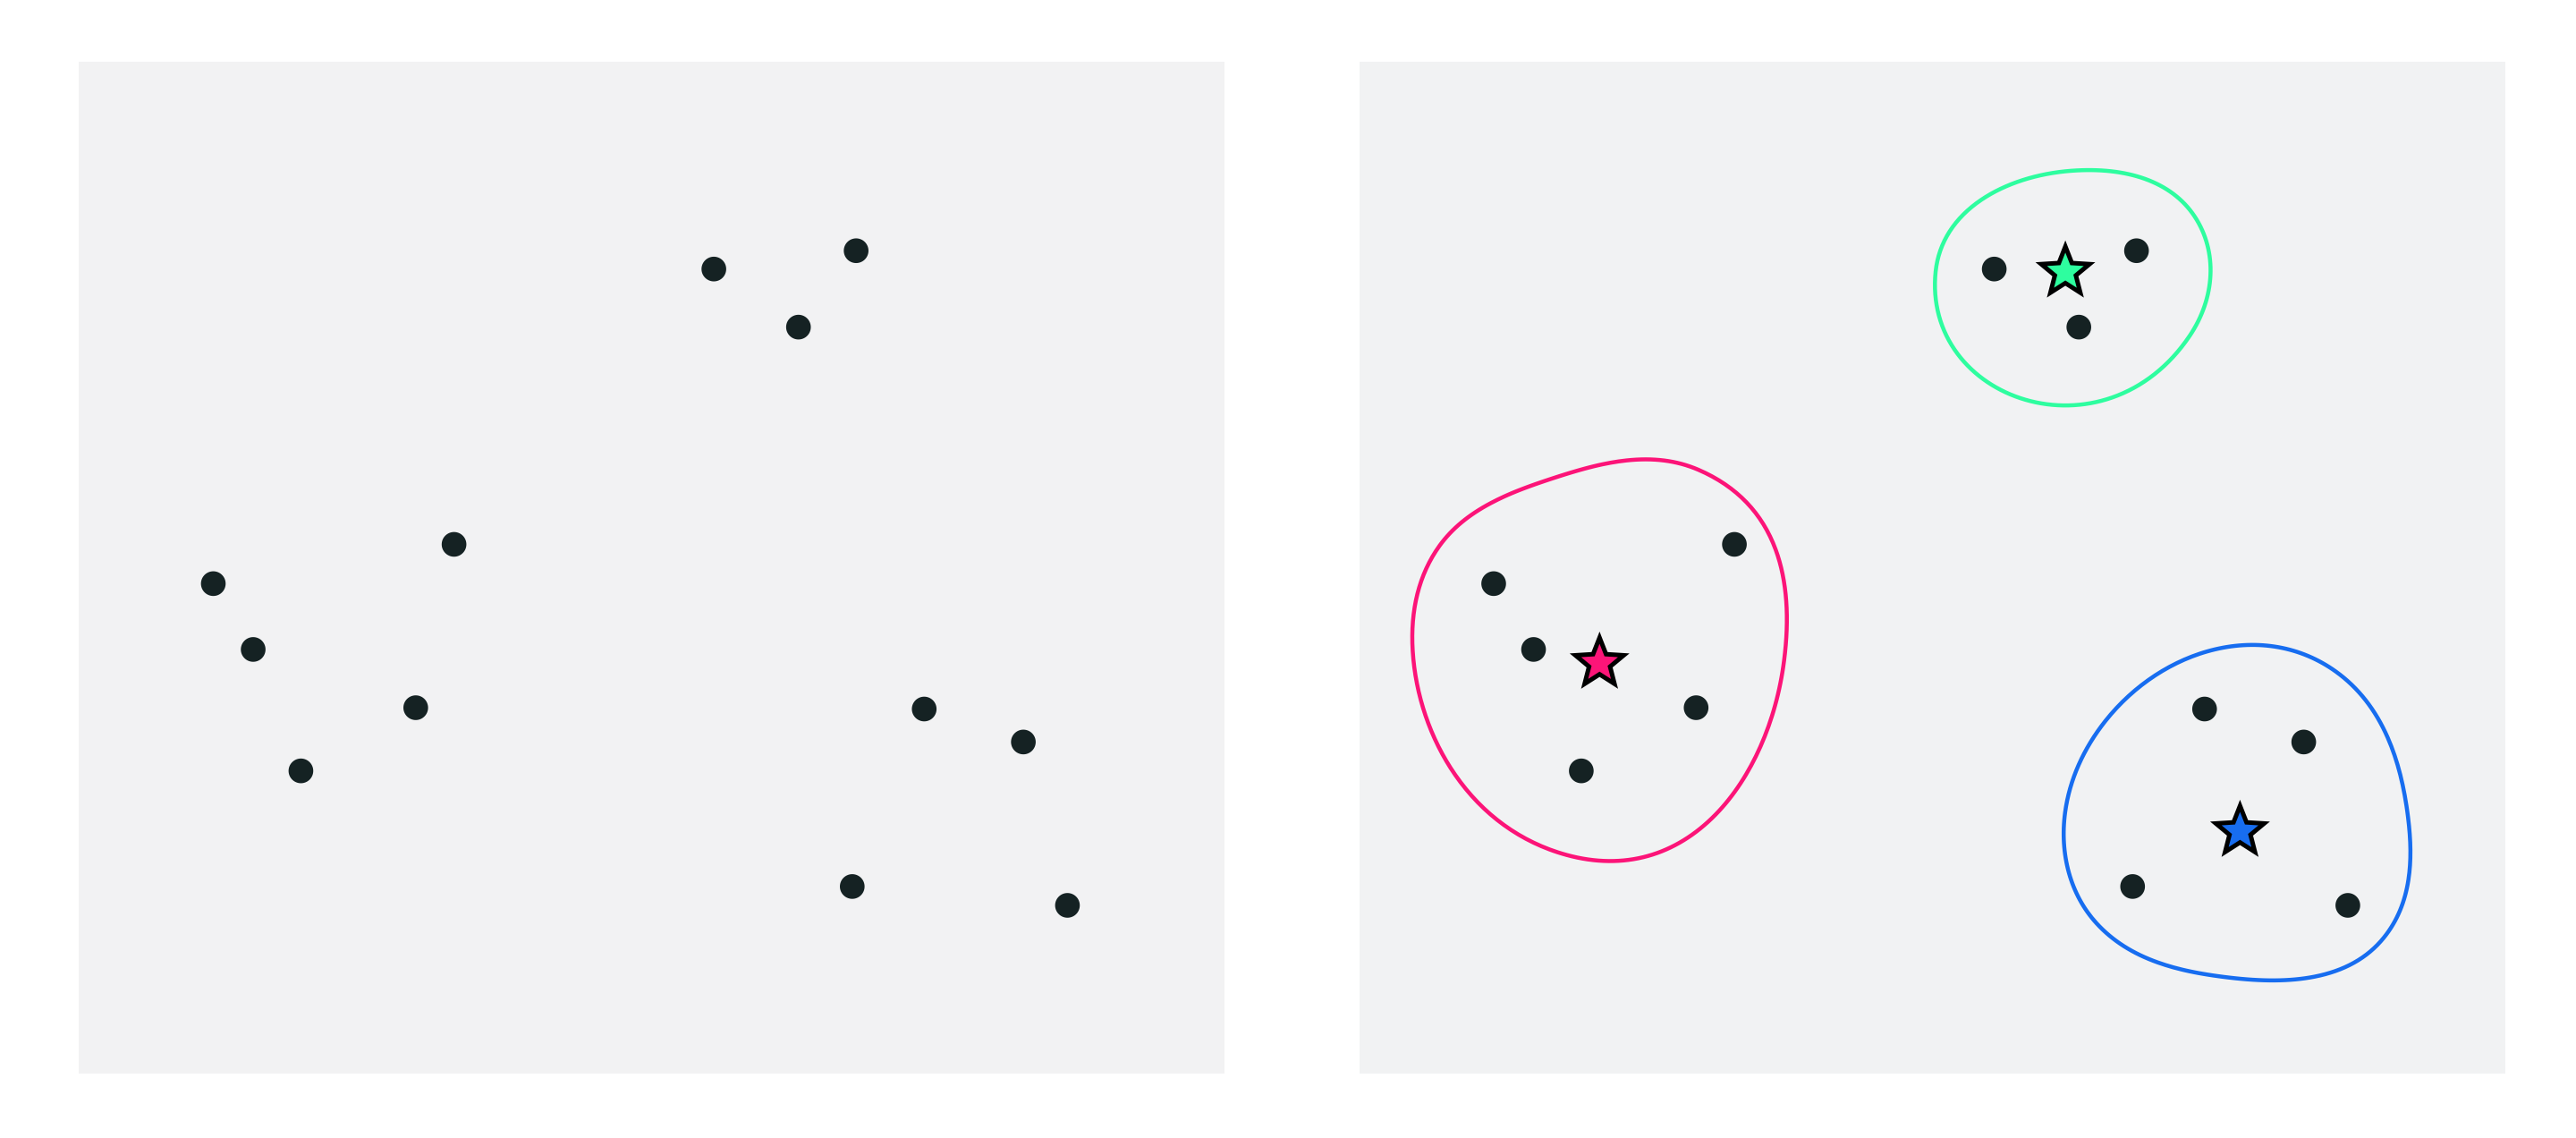

In [2]:
Image(image_path_1)

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> (left) A 2-dimensional toy dataset with $P=10$ data points. (right) The data shown naturally clustered into $K=3$ clusters.  Points that are geometrically close to one another belong to the same cluster, and each cluster boundary is roughly marked using a uniquely colored solid curve.  Each cluster center - also called a *centroid* - is marked by a star symbol colored to match its cluster boundary.</em>  </figcaption> 
</figure>

How can we describe - mathematically speaking - the clustering scenario we naturally see when we view the points in the left panel above, as highlighted in the right panel?  

First some notation.  As in the previous Sections we will denote our set of $P$ points generically as $\mathbf{x}_1,\,\mathbf{x}_2,\,...,\mathbf{x}_P$ where in our current instance $P=10)$ all of dimension $N$ (in our example here $N=2$).  To keep things as generally applicable as possible we will also use the notation $K$ to denote the number of clusters in a dataset, in our current example $K=3$.  Because each cluster has a centroid we need notation for this as well, and we will use $\mathbf{c}_1,\,\mathbf{c}_2,\,...,\mathbf{c}_K$ to denote these where $\mathbf{c}_k$ is the centroid of the $k^{th}$ cluster.  Finally we need a notation to denote the set of points that belong to each cluster.  We denote the set of indices of those points belonging to the $k^{th}$ cluster as

\begin{equation}
\mathcal{S}_k =  \left\{ p\,\, \lvert \,\,\text{if $\mathbf{x}_p$ belongs to the $k^{th}$ cluster } \right\}.
\end{equation}

With all of our notation in hand we can now better describe the prototype clustering scenario shown in the figure above.  Again, note here we have assumed that we have identified each cluster and its centroid 'bye eye'.  Firstly, because the centroid denotes the center of a cluster it seems intuitive that each one should be expressible as the average of the points assigned to each cluster.  Algebraically this is to say that

\begin{equation}
\mathbf{c}_k = \frac{1}{\left\vert\mathcal{S}_k\right\vert}\sum_{p\in\mathcal{S}_k}\mathbf{x}_p.
\end{equation}

This formula confirms the intuition that each centroid represents a chunk of the data - the average of those points belonging to each cluster.  

Next we can state mathematically an obvious and implicit fact about the clustering scenario above: that each point belongs to the cluster whose centroid it is closest to. To express this algebraically for a given point $\mathbf{x}_p$ is simply say that the point must belong to the cluster where the distance to the centroid $\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2$ is minimal.  In other words, the point $\mathbf{x}_p$ belongs to or is *assigned* to cluster $k^{\star}$ if

\begin{equation}
a_p = \underset{k=1,...,K}{\text{argmin}} \,\,\,\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2
\end{equation}

In the jargon of machine learning these are called cluster *assignments*.

## Learning clusters to represent data

We do not want to have to visually identify clusters in a dataset ourselves - and in any being constrained three dimensions if the dimension of of a dataset is greater than $N=3$ there is no way for us humans to do this anyway.  Instead we want an algorithm that will do this for us automatically.  Thankfully we can do this rather easily using the framework detailed above for mathematically describing clusters, the resulting algorithm being called the *K-means clustering algorithm*.  As with many of the algorithms we have seen K-means is an *iterative method*, meaning that we will refine the ideal location for our cluster centroids / cluster assignments over a number of update steps.

To get started -  let us say that we want to cluster a dataset of $P$ points into $K$ clusters automatically.  Note here that we will fix $K$, and address how to properly decide on its value later.  Now to state the obvious - remember - we know neither a) the locations of each cluster centroid nor b) the cluster assignments (i.e., which points are assigned to which cluster).

Since we do not know where the clusters nor their centroids are located we can start off by taking a random guess at the locations of our $K$ centroids (we have to start somewhere).  This 'random guess' - our initialization - for the $K$ centroids could be a random subset of $K$ of our points, or any number of [other types of initializations](https://stats.stackexchange.com/questions/317493/methods-of-initializing-k-means-clustering).  With our initial centroid locations decided on we can then determine cluster assignments by simply looping over our points and for each $\mathbf{x}_p$ finding its closest centroid using the formula we saw above

\begin{equation}
a_p = \underset{k=1,...,K}{\text{argmin}} \,\,\,\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2.
\end{equation}

Now we have both an initial guess at our centroids and clustering assignments.  With our cluster assignments in hand we can then update our centroid locations - as the average of the points assigned to each cluster

\begin{equation}
\mathbf{c}_k = \frac{1}{\left\vert\mathcal{S}_k\right\vert}\sum_{p\in\mathcal{S}_k}\mathbf{x}_p.
\end{equation}

These first three steps - initializing the centroids, assigning points to each cluster, and updating the centroid locations - are shown in the figure below.

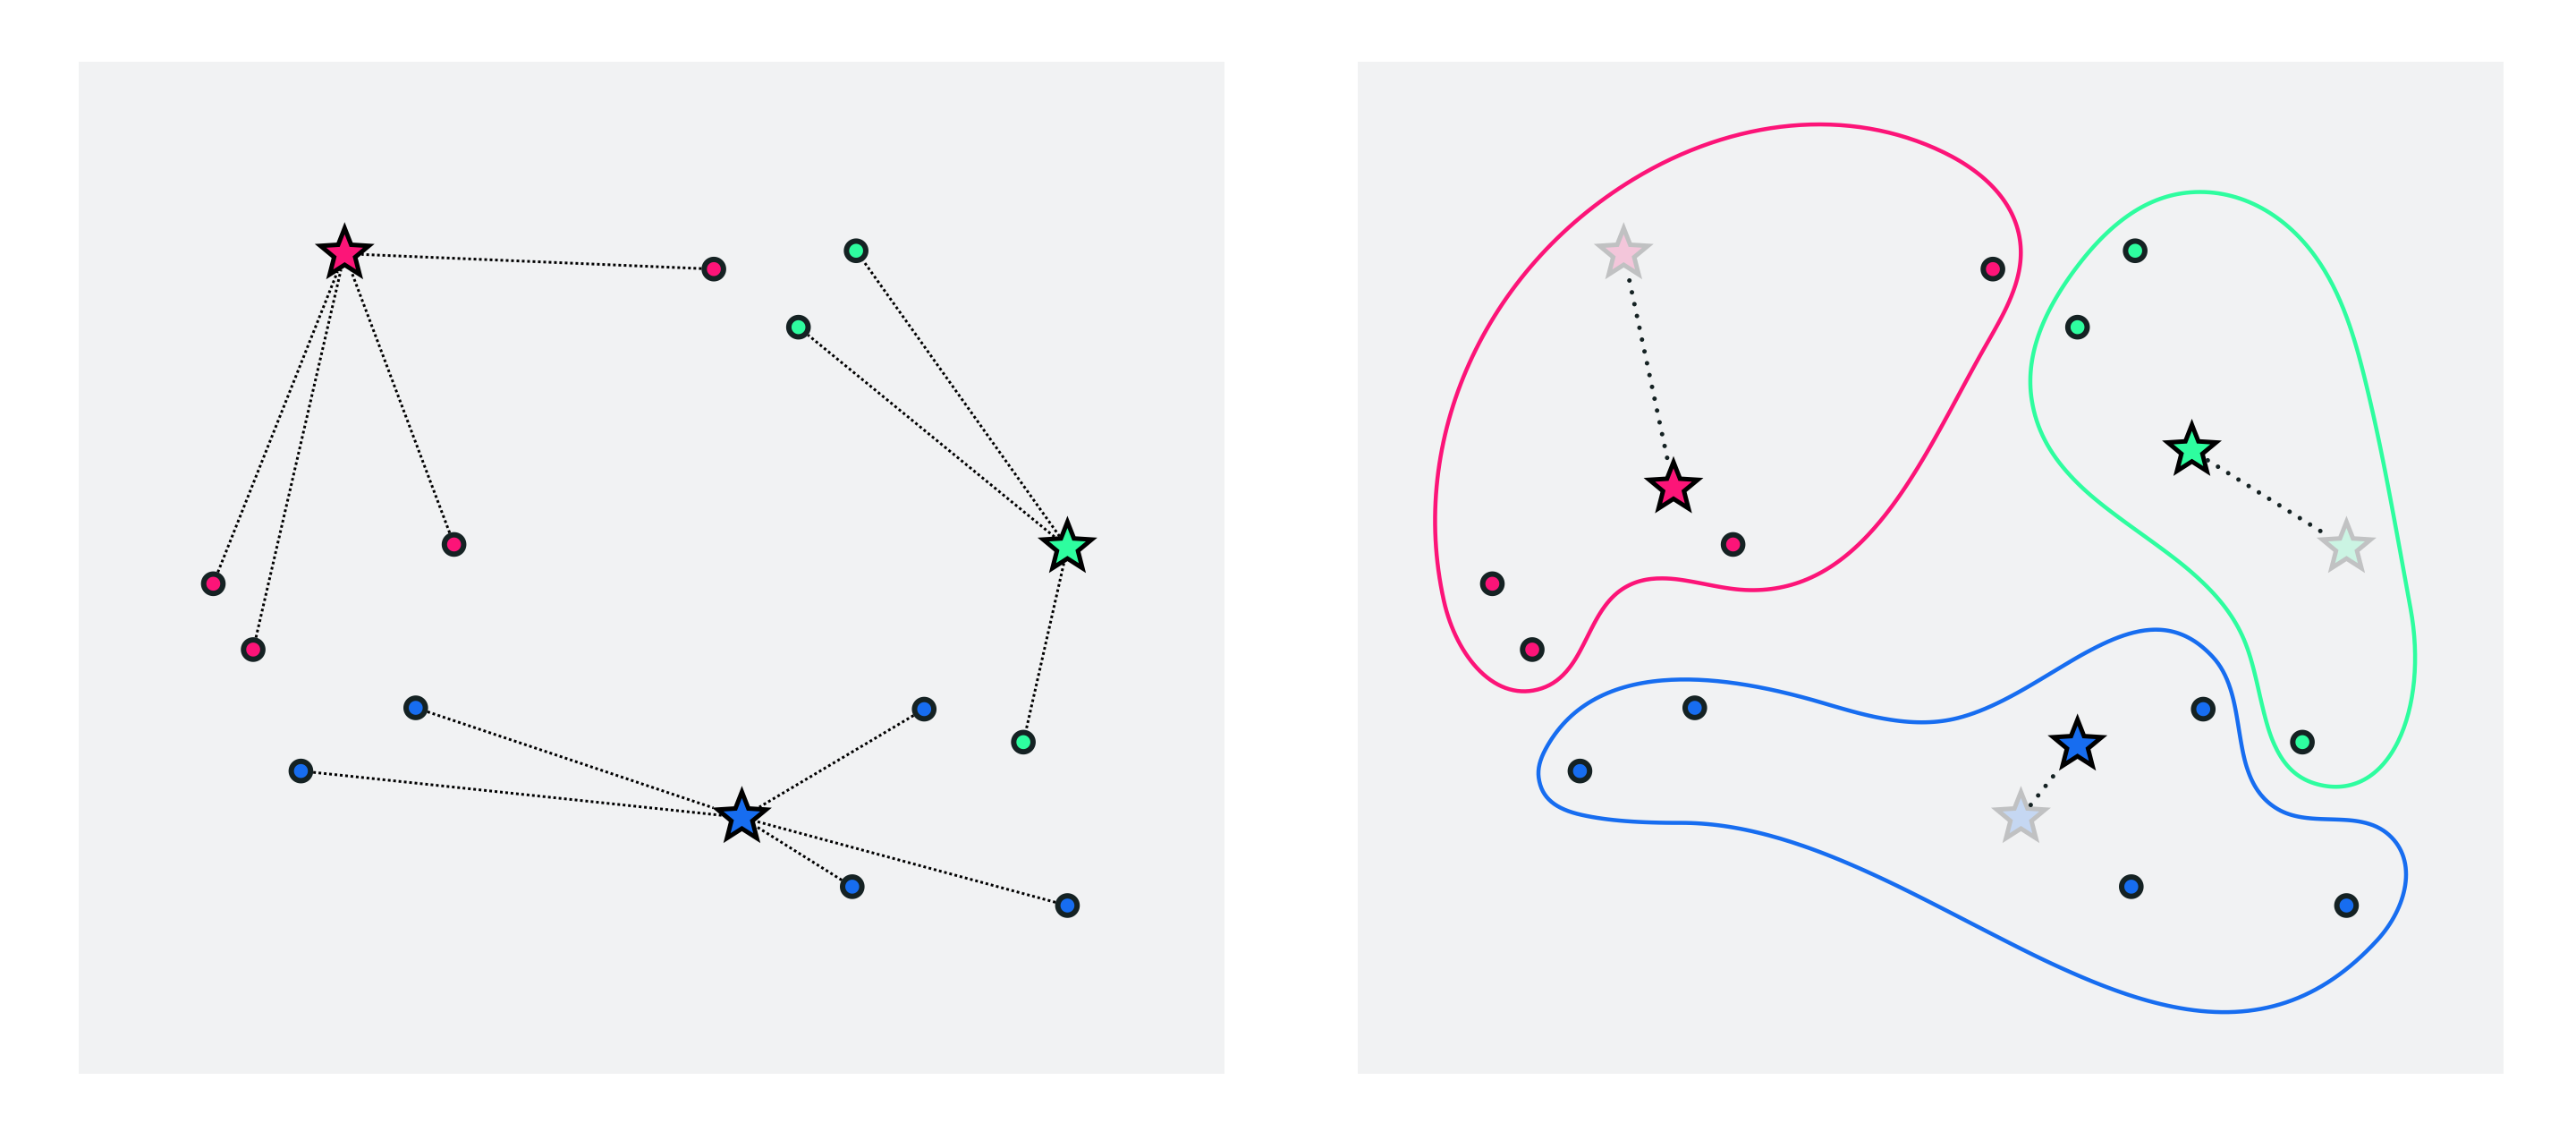

In [3]:
Image(image_path_2)

<figure>
  <figcaption>   
<strong>Figure 2:</strong> <em> (left) set of data points with random centroid initializations, and assignments (right) centroid locations updated as average of points assigned to each cluster </em>  </figcaption> 
</figure>

To further refine our centroids / clusters we can now just repeat the above two-step process of a) re-assigning points based on our new centroid locations and then b) updating the centroid locations as the average of those points assigned to each cluster.  We can halt doing so after e.g., a pre-defined number of maximum iterations or when the cluster centroids to not change location very much from one iteration to the next.

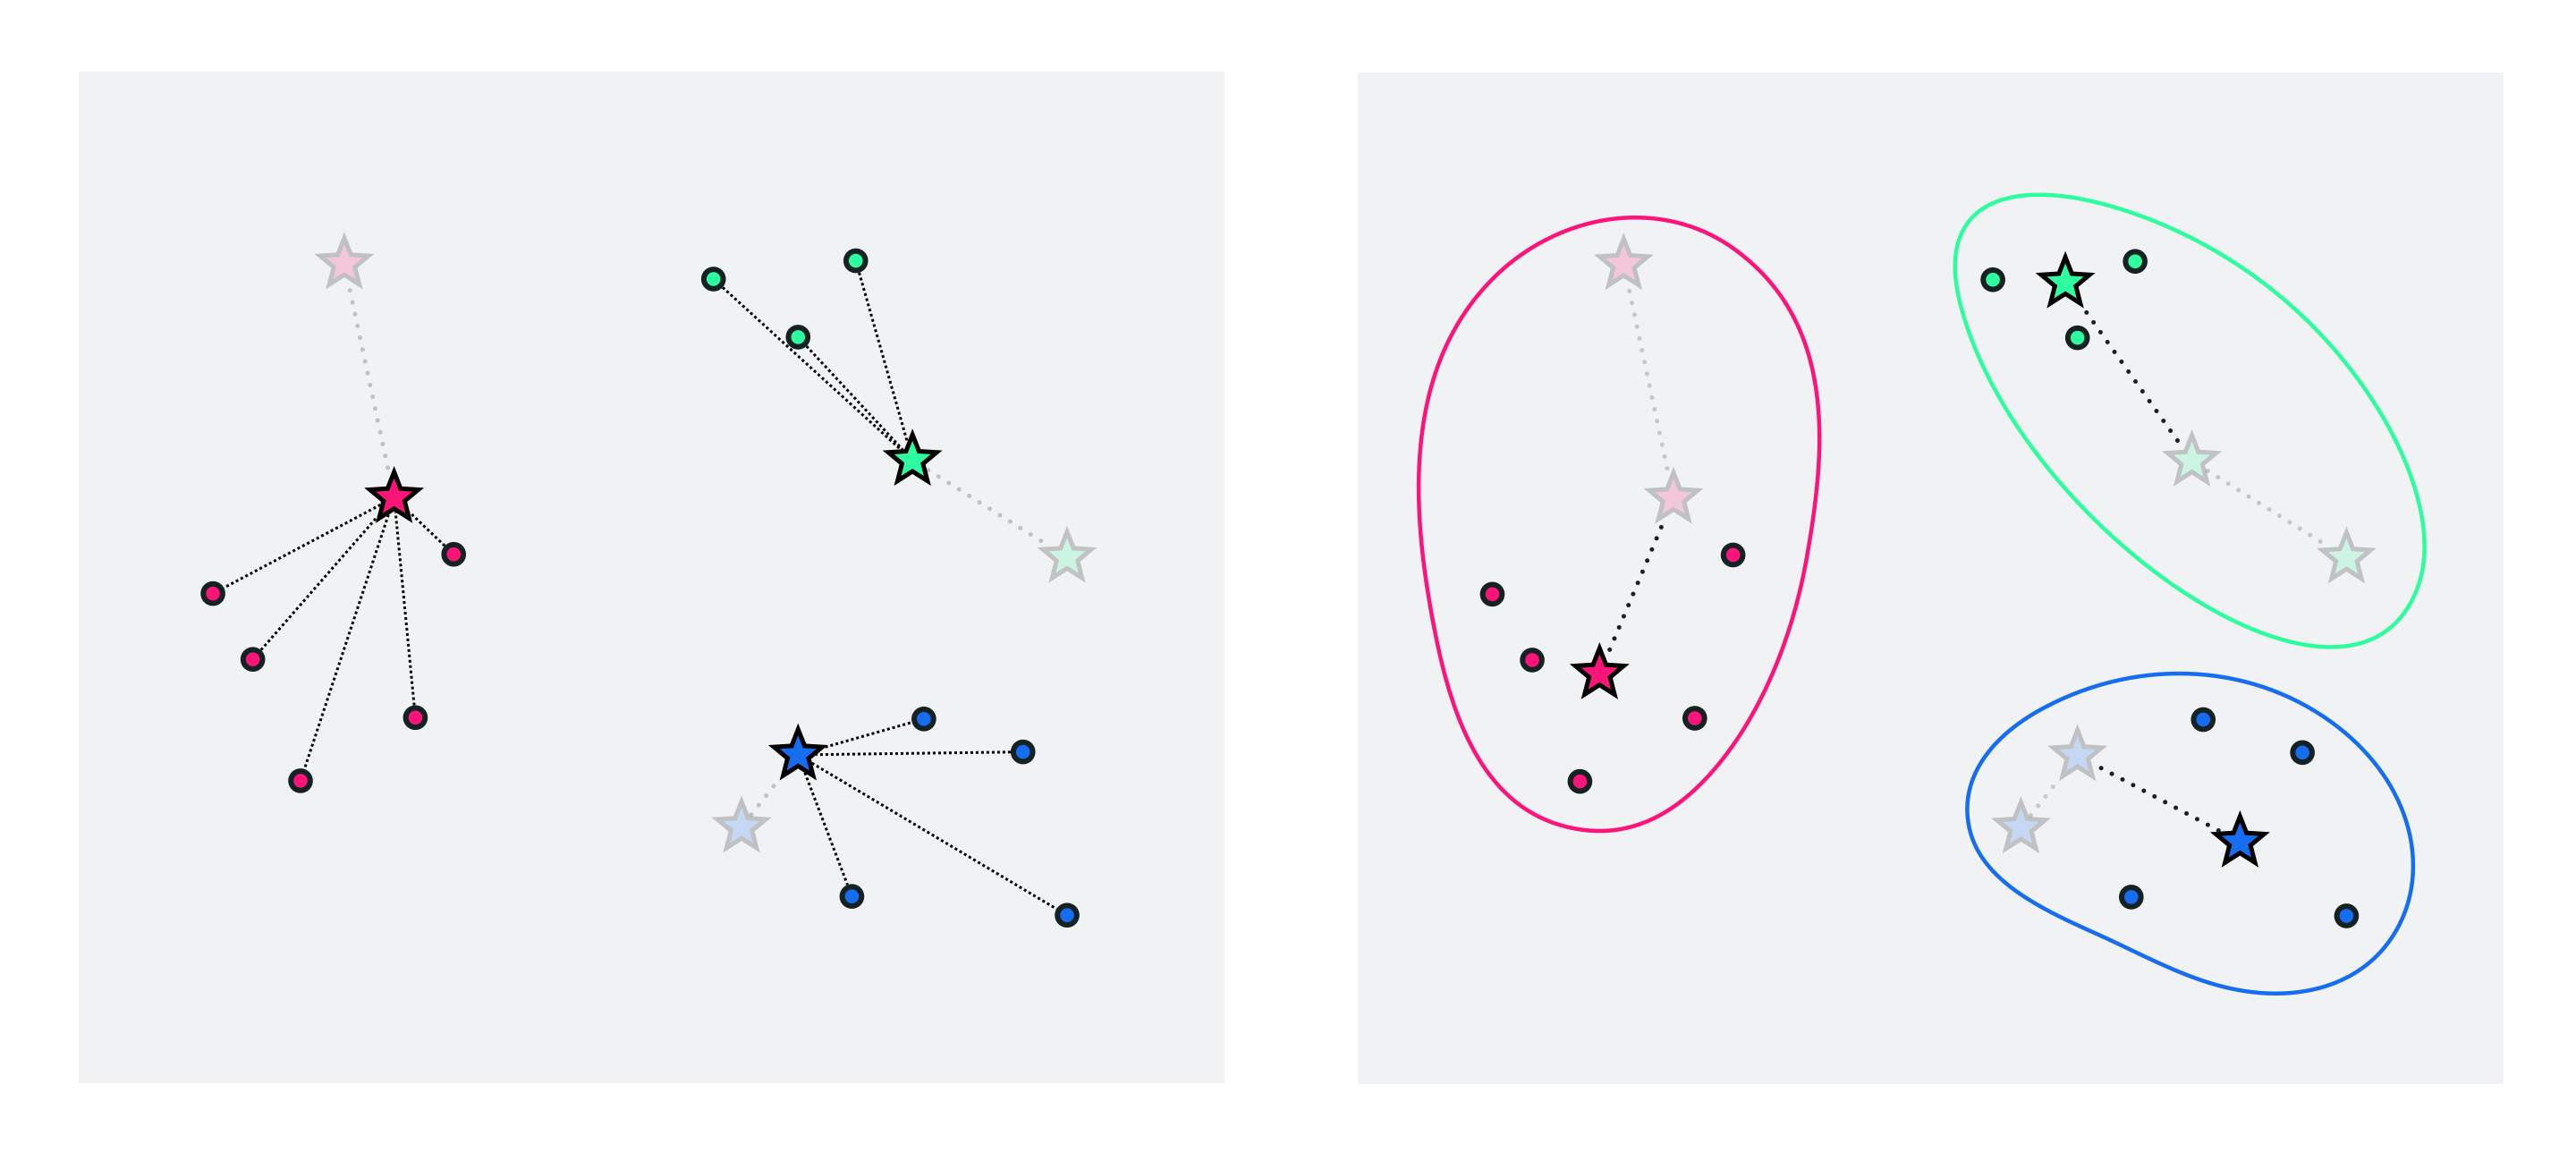

In [4]:
Image(image_path_3)

<figure>
  <figcaption>   
<strong>Figure 3:</strong> <em> (left) assigning points based on updated centroid locations (right) updated location of centroids given by cluster averages </em>  </figcaption> 
</figure>

This is the *K-means* algorithm - the pseudo-code of which is given below.  

### The K-means algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> dataset $\mathbf{x}_1,...,\mathbf{x}_P$, initializations for centroids $\mathbf{c}_1,...,\mathbf{c}_K$, and maximum number of iterations $J$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,j = 1,\ldots,J$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update cluster assignments</code><br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_p =\underset{k=1,\ldots,K}{\mbox{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}$<br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update centroid locations</code><br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,k = 1,\ldots,K$<br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; denote $\mathcal{S}_{k}$ the index set of points $\mathbf{x}_{p}$ currently assigned to the $k^{th}$ cluster<br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; update $\mathbf{c}_k$ via $\mathbf{c}_{k}=\frac{1}{\left|\mathcal{S}_{k}\right|}\underset{p\in\mathcal{S}_{k}}{\sum}\mathbf{x}_{p}$<br>

<strong>11:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp; <code>end for</code><br>

<strong>13:</strong>&nbsp;&nbsp; <code># Update cluster assignments using final centroids</code><br>

<strong>14:</strong>&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>15:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_p =\underset{k=1,\ldots,K}{\mbox{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}$<br>

<strong>16:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>17:</strong>&nbsp; <strong>output:</strong> optimal centroids and assignments<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

Below we have a simple Python implementation of the pseudo-code above, that is used in the examples that follow.

In [5]:
####### K-means functionality #######
# function for updating cluster assignments
def update_assignments(data,centroids):
    P = np.shape(data)[1]
    assignments = []
    for p in range(P):
        # get pth point
        x_p = data[:,p][:,np.newaxis]
        
        # compute distance between pth point and all centroids
        # using numpy broadcasting
        diffs = np.sum((x_p - centroids)**2,axis = 0)
        
        # determine closest centroid
        ind = np.argmin(diffs)
        assignments.append(ind)
    return np.array(assignments)
       
# update centroid locations
def update_centroids(data,old_centroids,assignments):
    K = old_centroids.shape[1]
    # new centroid container
    centroids = []
    for k in range(K):
        # collect indices of points belonging to kth cluster
        S_k = np.argwhere(assignments == k)
        
        # take average of points belonging to this cluster
        c_k = 0
        if np.size(S_k) > 0:
            c_k = np.mean(data[:,S_k],axis = 1)
        else:  # what if no points in the cluster?  keep previous centroid
            c_k = copy.deepcopy(old_centroids[:,k])[:,np.newaxis]
        centroids.append(c_k)
    centroids = np.array(centroids)[:,:,0]
    return centroids.T

# main k-means function
def my_kmeans(data,centroids,max_its):    
    # outer loop - alternate between updating assignments / centroids
    for j in range(max_its):
        # update cluter assignments
        assignments = update_assignments(data,centroids)
        
        # update centroid locations
        centroids = update_centroids(data,centroids,assignments)
        
    # final assignment update
    assignments = update_assignments(data,centroids)
    return centroids,assignments

We show how to call the ``K-means`` implementation in the cell below for a given dataset ``data``.

In [6]:
# load in a toy dataset for demonstrating K-means
data = np.loadtxt('chapter_8_datasets/5cluster_2d_data.csv',delimiter = ',')

# initialize centroids as random points, pick a number 
# clusters K to try, and set maximum iterations
r = np.arange(np.shape(data)[1])
num_clusters = 3
pts = np.random.permutation(r)[:num_clusters]
iniit_centroids = data[:,pts]
max_its = 10

# run k-means implementation above
centroids,assignments = my_kmeans(data,iniit_centroids,max_its)

#### <span style="color:#a50e3e;">Example 1: </span> K-means and bad local minima 

In this example we use the ``Python`` K-means implementation above to animate the K-means clustering process for the toy dataset loaded in and plotted in the next cell.

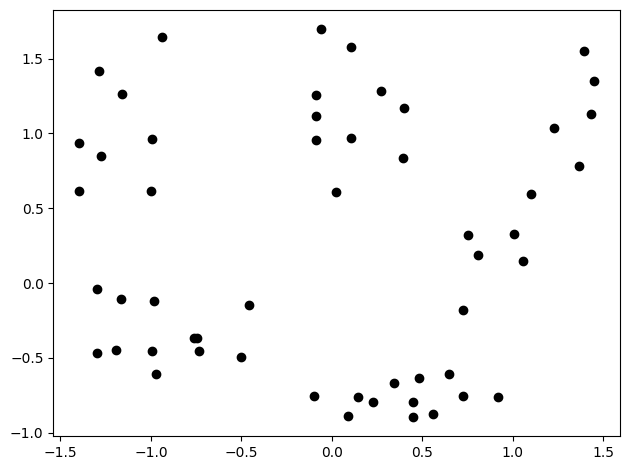

In [7]:
# scatter plot the dataset 
plt.scatter(data[0,:],data[1,:],c = 'k')
plt.show()

This roughly looks like it could be clustered into $K=5$ clusters.  Let us try applying K-means using $K=5$ to see if the algorithm can recover them properly.

Below we run and animate the K-means algorithm using $K=5$ via the animation function called ``unsuperlib.K_means_demos.run_animated_demo``, which contains a version of the ``K-means`` implementation above.  This animator displays each iteration of the algorithm is three frames.  Beginning with the first iteration, the dataset is shown with the initialized centroids - here chosen as $K$ random points from the dataset - displayed as stars each with a unique color.  Next the first assignment step is performed, and we plot dashed lines connecting each point to its closest centroid (these are colored using the unique color of the cluster centroid to which each point is assigned).  Once assigned, the points are then colored the unique color for the respective cluster.  In the subsequent frame the average of each cluster's assigned points is illustrated, with dashed lines from each cluster converging to its new centroid.  This same set of frames is then shown for each subsequent iteration of the algorithm with the iteration number printed at the top of each frame.   Moving the slider from left to right progresses the algorithm from the initialization to the final iteration.

In [8]:
# # initialize centroids as random points and set maximum number of iterations - uncomment to re-render animation
# random_pts = np.array([13, 10, 23, 27, 48])
# init_centroids = data[:,random_pts]
# max_its = 8

# # run K-means animator using Python implementation above
# section_8_5_helpers.run_animated_demo(video_path_1,data,init_centroids,max_its,fps=0.5)

In [9]:
show_video(video_path_1)

Pushing the slider all the way to the right we can see that indeed the algorithm does identify five chunks of the data that indeed appear to be proper clusters.

#### <span style="color:#a50e3e;">Example 2: </span> K-means failures due to a poor choice of initialization

In this example we show how K-means can fail due to a poor choice of initial centroids.  This is a point we will return to as well when we later discuss the K-means algorithm in the framework of general *Matrix Factorization Problems*, where we will see how the K-means algorithm can be understood as the minimization of a very non-convex cost function paradigm.  Regardless, one can intuit that the quality of a K-means clustering surely depends on a high quality initialization.  What does a good initialization look like?  Generally speaking, a good initializations is one where the initial centroids are spread evenly throughout the distribution of the data, as this allows the algorithm to better find individual clusters.  Conversely, a poor initialization is typically one where all of the initial centroids are bunched up together in a small region of the space.  This can make it difficult for the centroids to spread out effectively, leading to less than optimal clusterings or even 'empty clusters' (i.e., those to which no points are finally assigned).

Using a toy dataset we illustrate two examples of this behavior below.  Here the initial centroids have been chosen as points in the dataset, and very particularly to illustrate these behaviors.  Because in practice we may choose initial centroids e.g., as random points from our dataset these problems may not occur so frequently, but they are still a danger.

Note that in this example using scikit-learn's [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) functionality to form a randomly generated dataset.

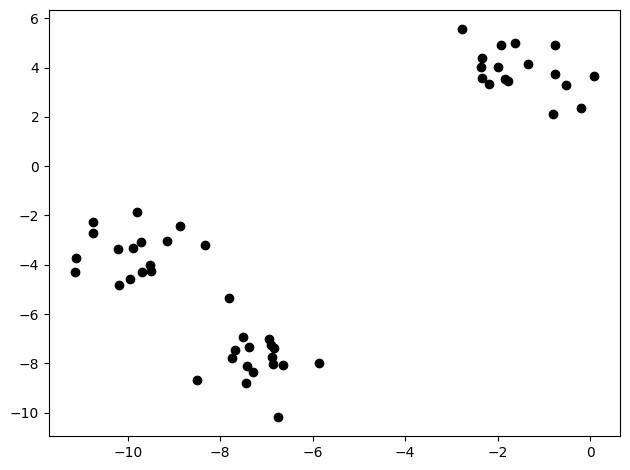

In [10]:
# Loading the data
import pickle
with open("chapter_8_datasets/blobs.pickle", "rb") as input_file:
    data = pickle.load(input_file)

plt.scatter(data[0,:],data[1,:],c = 'k')
plt.show()

The first and most fundamental issue is that of *empty clusters*, meaning clusters with no points assigned to them.  It is indeed possible, for some unfortunate initialization choices, for clusters to end up being empty when running K-means.  This is not an overly common occurrence, but is still worth noting. 

We illustrate the empty-cluster problem below - where we make a run of $K = 3$ K-means clustering using the dataset above and a particular random initialization for the cluster centroids.  Here we choose a completely random set of points to initialize our centroids with, instead of a random subset of our training data, because it is easier to 'trip up' K-means doing so.  The animation / slider mechanism below works precisely as in the previous example, with each iteration shown in multiple frames, and moving the slider left to right controlling the iteration of K-means being shown.

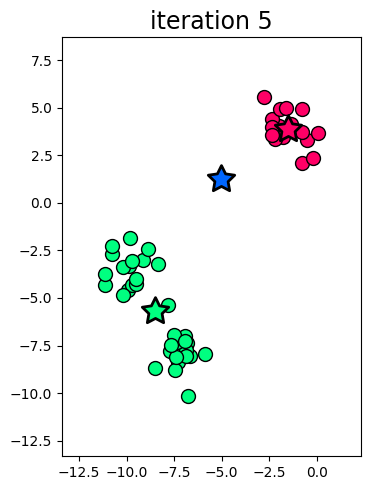

In [11]:
# a random initialization
init_centroids = np.array([[-0.57069626, -1.49710357,  0.02538411],
                           [ 1.77397192,  2.98237079,  0.53539765]])

# run K-means animator using Python implementation above
section_8_5_helpers.run_animated_demo(video_path_2,data,init_centroids,max_its = 5,fps=0.5)

In [12]:
show_video(video_path_2)

Notice here how - due to the centroid initializations - the blue cluster very quickly becomes empty (every point is closer to one of the other two centroids) and never recovers any assigned points.  

This problem can be easily detected in practice (simply count up the number of assignments at the end of a run of K-means), and re-running with a different initialization is typically the anecdote.

The second issue to keep note of with K-means is the *sub-optimal clustering*.  This means that although the proper number of clusters $K$ was chosen the final clustering itself fails to fully capture the cluster-structure of the data.  The animation below illustrates this failure on the same dataset used above.  Here we can see that - due to the initialization - the single cluster in the top of the image is cleaved in two, while the two lower clusters are identified a single massive cluster.

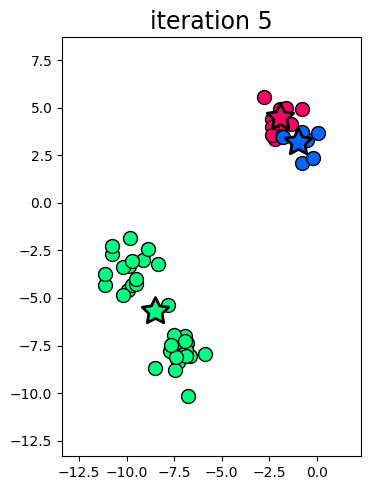

In [13]:
# initial centroids - here particular chosen
pt_inds = [20,21,22]
init_centroids = data[:,pt_inds]

# run K-means animator using Python implementation above
section_8_5_helpers.run_animated_demo(video_path_3,data,init_centroids,max_its = 5,fps=0.5)

In [17]:
show_video(video_path_3)

Once again the best antidote for this issue is to simply re-run the algorithm with a different initialization.  

To determine the best clustering from set of runs we can use the *average distance of each point to its cluster centroid* - called the *average intra-cluster distance* - as an objective measure to rank the runs.  Denoting $\mathbf{c}_{k_p}$ the final cluster centroid of the $p^{th}$ point $\mathbf{x}_p$, then the average distance from each point to its respective centroid can be written as

\begin{equation}
\text{average intra-cluster distance} = \frac{1}{P}\sum_{p=1}^P \left \Vert \mathbf{x}_p - \mathbf{c}_{k_p} \right \Vert_2.
\end{equation}

Computing this for each run of K-means we choose the final clustering that achieves the *smallest* such value as the best clustering arrangement.

To illustrate the usage of the intra-cluster distance as a measurement for the quality of a clustering run, below we run ``K-means`` using the previous two initializations as well as one additional one that results in a perfect clustering on the toy dataset above.  We then plot the final clustering provided by each initialization - with the average intra-cluster distance in each printed above the panel.

/Users/jeremywatt/Desktop/machine-learning-refined/notes/8_Linear_unsupervised_learning/./chapter_8_library/section_8_5_helpers.py:292: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(final_centroids[0,k],final_centroids[1,k],c = colors[k],s = 400,edgecolor ='k',linewidth = 2,marker=(5, 1),zorder = 3)


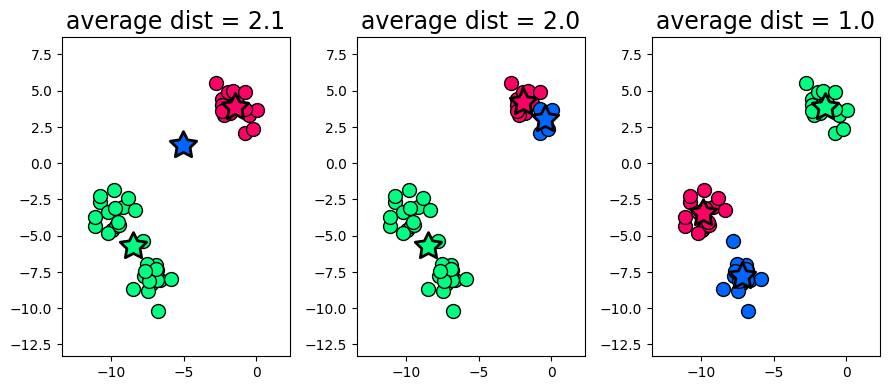

In [15]:
# our first initialization --> leading to an empty cluster
init_centroids_1 = np.array([[-0.57069626, -1.49710357,  0.02538411],
                           [ 1.77397192,  2.98237079,  0.53539765]])

# our second initialization --> leading to a sub-optimal clustering
pt_inds = [20,21,22]
init_centroids_2 = data[:,pt_inds]

# our third initialization --> leading to a perfect clustering
pt_inds = np.array([13, 10, 23])
init_centroids_3 = data[:,pt_inds]

# run K-means with each initialization above and plot the resulting clustering
init_centroids = [init_centroids_1,init_centroids_2,init_centroids_3]
section_8_5_helpers.compare_runs(data,init_centroids,max_its = 10)

Here we can see how the average intra-cluster distance provides us with a simple numerical way to compare the quality of various clusterings (when $K$ is fixed). Above we can see how in this instance the empty-cluster scenario (left panel) provided the worst value, the sub-optimal clustering (middle panel) a slightly lower value, and the optimal clustering (right panel) a significantly lower value. 

#### <span style="color:#a50e3e;">Example 3: </span>  Choosing the ideal number of clusters $K$

To determine the optimal setting of the parameter $K$ - i.e., the number of clusters in which to cluster the data - we typically must try a range of different values for $K$, run the K-means algorithm in each case, and compare the results using the average intra-cluster distance.  Of course if we achieve an optimal clusterings for each value of $K$ (perhaps running the algorithm multiple times for each value of $K$) then the intra-cluster distance should *always go down as we increase the value of $K$* since we are partitioning the dataset into more and more small chunks. 

For example, in the Python cell below we plot the intra-cluster distance for the dataset used in the previous example resulting from 10 runs of K-means using $K=1,\ldots,10$, with a maximum number of 10 iterations per run.  This plot is often referred to in the jargon of machine learning as a *scree plot*.

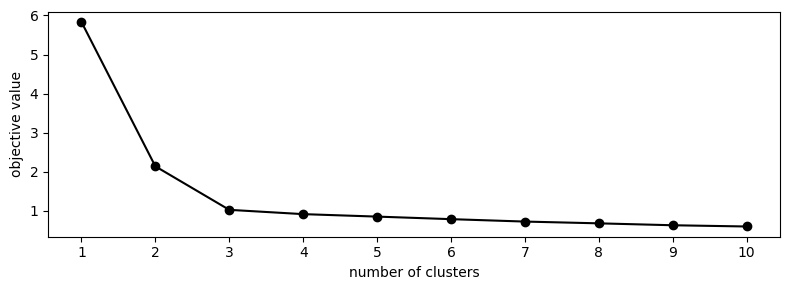

In [16]:
# scree plot
K_range = [1,2,3,4,5,6,7,8,9,10]
section_8_5_helpers.scree_plot(data,K_range,max_its = 10)

As one should expect, the intra-cluster distance decreases monotonically as we increase $K$. Notice, however that the scree plot above has an *elbow* at $K=3$, meaning that increasing the number of clusters from $3$ to $4$ and onwards reduces the objective value by very little. Because of this we can argue that $K=3$ is a good choice for the number of clusters for this particular dataset (as we saw in the prior example, it is indeed the optimal number) since any fewer clusters and the intra-cluster distance is comparatively large, while adding additional clusters does not decrease the total intra-cluster distance too much.

This illustrates the typical usage of the *scree plot* for deciding on an ideal number of clusters $K$ for K-means.  We compute and then plot the intra-cluster distance over a range of values for $K$, and pick the value at the 'elbow' of the plot.

<a id='endnotes'></a>
## References

[1] D’Haeseleer, P. How does gene expression clustering work? Nature Biotechnology. 23, 1499–1501, (2005).

[2] Eisen, M.B., Spellman, P.T., Brown, P.O. and Botstein, D. Cluster analysis and display of genome-wide expression patterns. Proc. Natl. Acad. Sci. USA 95, 14863–14868, (1998).